# Определение перспективного тарифа для телеком-компании

## Описание проекта:

Имеются данные федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В моем распоряжении данные 500 пользователей компании: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов** 

* **Тариф «Смарт»**
  * Ежемесячная плата: 550 рублей
  * Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
  * Стоимость услуг сверх тарифного пакета:
  * минута разговора: 3 рубля
  * сообщение: 3 рубля
  * 1 Гб интернет-трафика: 200 рублей
  
* **Тариф «Ультра»**
  * Ежемесячная плата: 1950 рублей
  * Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
  * Стоимость услуг сверх тарифного пакета:
  * минута разговора: 1 рубль
  * сообщение: 1 рубль
  * 1 Гб интернет-трафика: 150 рублей

*Примечание*

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

## Обзор данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import os

# импорт необходимых библиотек
sns.set_theme(style="white", palette='pastel')

In [2]:
if os.path.exists('/datasets/calls.csv'):
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv', index_col=0)
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')
elif os.path.exists('./datasets/users.csv'):
    calls = pd.read_csv('./datasets/calls.csv')
    internet = pd.read_csv('./datasets/internet.csv', index_col=0)
    messages = pd.read_csv('./datasets/messages.csv')
    tariffs = pd.read_csv('./datasets/tariffs.csv')
    users = pd.read_csv('./datasets/users.csv')
# загружаем данные

In [3]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [7]:
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [9]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [10]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [11]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


**Вывод:**

* `calls`
  * Пропусков нет
  * Колонку `call_date` привести к `datetime`
* `internet`
  * Пропусков нет
  * `session_date` к `datetime`
  * Ненужную колонку без названия удалить (Исправил при чтении файла)
* `messages`
  * Пропусков нет
  * `message_date` к `datetime`
* `tariffs`
  * Тут всё ок
* `users`
  * Есть пропуски в `churn_date`, но похоже, это нормально, потому что это абоненты, отключившие тарифы 
  * `churn_date`, `reg_date` привести к `datetime`

В данных есть звонки с 0-ой продолжительностью и количество потраченных mb 0. В первом случае это отклоненный звонок, во втором человек не включал интернет.

## Подготовка данных

In [13]:
# меняем типы данных
calls['call_date'] = pd.to_datetime(calls['call_date'], errors='ignore')
internet['session_date'] = pd.to_datetime(internet['session_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])

In [14]:
# проверяем
users.dtypes

user_id                int64
age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object

In [15]:
calls.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


In [16]:
internet.describe().T

,count,mean,std,min,25%,50%,75%,max
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


In [17]:
messages.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,123036.0,1256.98941,143.523967,1000.0,1134.0,1271.0,1381.0,1499.0


In [18]:
tariffs.describe().T

,count,mean,std,min,25%,50%,75%,max
messages_included,2.0,525.0,671.751442,50.0,287.5,525.0,762.5,1000.0
mb_per_month_included,2.0,23040.0,10861.160159,15360.0,19200.0,23040.0,26880.0,30720.0
minutes_included,2.0,1750.0,1767.766953,500.0,1125.0,1750.0,2375.0,3000.0
rub_monthly_fee,2.0,1250.0,989.949494,550.0,900.0,1250.0,1600.0,1950.0
rub_per_gb,2.0,175.0,35.355339,150.0,162.5,175.0,187.5,200.0
rub_per_message,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0
rub_per_minute,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0


In [19]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


Аномальных значений не обнаружено. Таблица тарифов соответствует описанию

### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [20]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [21]:
calls_info = calls.pivot_table(index=['user_id', calls.call_date.dt.month],
                               values='duration',
                               aggfunc={'count', 'sum'})
calls_info.columns = ['num_calls', 'total_duration']
calls_info.index.names = ['user_id', 'month']

In [22]:
calls_info

num_calls  total_duration
user_id month                           
1000    5             22          150.06
        6             43          158.90
        7             47          318.80
        8             52          389.87
        9             58          440.14
...                  ...             ...
1498    10            41          232.63
1499    9              9           64.65
        10            68          429.91
        11            74          576.50
        12            69          465.16

[3174 rows x 2 columns]

### Количество отправленных сообщений по месяцам

In [23]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [24]:
messages_info = messages.pivot_table(index=['user_id', messages.message_date.dt.month], values='id', aggfunc='count')
messages_info.columns = ['total_messages']
messages_info.index.names = ['user_id', 'month']

In [25]:
messages_info

total_messages
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
...                       ...
1498    10                 42
1499    9                  11
        10                 48
        11                 59
        12                 66

[2717 rows x 1 columns]

### Объем израсходованного интернет-трафика по месяцам

In [26]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [27]:
internet_info = internet.pivot_table(index=['user_id', internet.session_date.dt.month], 
                                     values='mb_used', 
                                     aggfunc='sum')
internet_info.index.names = ['user_id', 'month']

In [28]:
internet_info

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
...                 ...
1498    10     20579.36
1499    9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[3203 rows x 1 columns]

Теперь соединим все эти таблички вместе. У нас их получилось три: `calls_info`, `messages_info`, `internet_info`

In [29]:
# сначала соединяем internet_info с messages_info, а потом еще и calls_info
df = internet_info.merge(messages_info, on=['user_id', 'month'], how='left')
df = df.merge(calls_info, on=['user_id', 'month'], how='left')

In [30]:
df

mb_used  total_messages  num_calls  total_duration
user_id month                                                     
1000    5       2253.49            22.0       22.0          150.06
        6      23233.77            60.0       43.0          158.90
        7      14003.64            75.0       47.0          318.80
        8      14055.93            81.0       52.0          389.87
        9      14568.91            57.0       58.0          440.14
...                 ...             ...        ...             ...
1498    10     20579.36            42.0       41.0          232.63
1499    9       1845.75            11.0        9.0           64.65
        10     17788.51            48.0       68.0          429.91
        11     17963.31            59.0       74.0          576.50
        12     13055.58            66.0       69.0          465.16

[3203 rows x 4 columns]

Теперь пристыкуем таблицу тарифов. Чтобы ее пристыковать, нам надо сначала пристыковать таблицу юзеров через `user_id`, а потом через колонку этой таблицы `tariff_name` пристыковать таблицу тарифов.

In [31]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

In [32]:
tariff_info = users.merge(tariffs, on='tariff', how='left')
tariff_info

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,500,550,200,3,3
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,1000,30720,3000,1950,150,1,1
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart,50,15360,500,550,200,3,3
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart,50,15360,500,550,200,3,3
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,50,15360,500,550,200,3,3


In [33]:
tariff_info = tariff_info.drop(columns=['age', 'churn_date', 'first_name', 'last_name', 'reg_date'])
tariff_info.columns

Index(['user_id', 'city', 'tariff', 'messages_included',
       'mb_per_month_included', 'minutes_included', 'rub_monthly_fee',
       'rub_per_gb', 'rub_per_message', 'rub_per_minute'],
      dtype='object')

In [34]:
df = df.reset_index().merge(tariff_info, on='user_id', how='left')
df.columns

Index(['user_id', 'month', 'mb_used', 'total_messages', 'num_calls',
       'total_duration', 'city', 'tariff', 'messages_included',
       'mb_per_month_included', 'minutes_included', 'rub_monthly_fee',
       'rub_per_gb', 'rub_per_message', 'rub_per_minute'],
      dtype='object')

### Помесячная выручка с каждого пользователя.

Считаем по месяцам для каждого пользователя отдельно доход по звонкам, месседжам, интернету, а потом складываем это всё вместе и добавляем фиксированную плату. Получаем выручку в столбец `revenue`

In [35]:
df.loc[df['total_duration'] > df['minutes_included'], 'revenue_call'] = \
np.ceil(df['total_duration'] - df['minutes_included']) * df['rub_per_minute']
df['revenue_call'] = df['revenue_call'].fillna(0)

In [36]:
df.loc[df['total_messages'] > df['messages_included'], 'revenue_messages'] = \
np.ceil(df['total_messages'] - df['messages_included']) * df['rub_per_message']
df['revenue_messages'] = df['revenue_messages'].fillna(0)

In [37]:
df.loc[df['mb_used'] > df['mb_per_month_included'], 'revenue_internet'] = \
np.ceil((df['mb_used'] - df['mb_per_month_included']) / 1024) * df['rub_per_gb']
df['revenue_internet'] = df['revenue_internet'].fillna(0)

In [38]:
df['revenue'] = df['revenue_call'] + df['revenue_messages'] \
+ df['revenue_internet'] + df['rub_monthly_fee']

In [39]:
df.loc[:, 'revenue_call':]

,revenue_call,revenue_messages,revenue_internet,revenue
0,0.0,0.0,0.0,1950.0
1,0.0,0.0,0.0,1950.0
2,0.0,0.0,0.0,1950.0
3,0.0,0.0,0.0,1950.0
4,0.0,0.0,0.0,1950.0
...,...,...,...,...
3198,0.0,0.0,1200.0,1750.0
3199,0.0,0.0,0.0,550.0
3200,0.0,0.0,600.0,1150.0
3201,231.0,27.0,600.0,1408.0


Теперь можно дропнуть колонки для промежуточных рассчетов `revenue`

In [40]:
df = df.drop(columns=['revenue_call', 'revenue_messages', 'revenue_internet'])

In [41]:
df

,user_id,month,mb_used,total_messages,num_calls,total_duration,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,1000,5,2253.49,22.0,22.0,150.06,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950.0
1,1000,6,23233.77,60.0,43.0,158.90,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950.0
2,1000,7,14003.64,75.0,47.0,318.80,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950.0
3,1000,8,14055.93,81.0,52.0,389.87,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950.0
4,1000,9,14568.91,57.0,58.0,440.14,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198,1498,10,20579.36,42.0,41.0,232.63,Владикавказ,smart,50,15360,500,550,200,3,3,1750.0
3199,1499,9,1845.75,11.0,9.0,64.65,Пермь,smart,50,15360,500,550,200,3,3,550.0
3200,1499,10,17788.51,48.0,68.0,429.91,Пермь,smart,50,15360,500,550,200,3,3,1150.0
3201,1499,11,17963.31,59.0,74.0,576.50,Пермь,smart,50,15360,500,550,200,3,3,1408.0


## Анализ данных

In [42]:
df.columns

Index(['user_id', 'month', 'mb_used', 'total_messages', 'num_calls',
       'total_duration', 'city', 'tariff', 'messages_included',
       'mb_per_month_included', 'minutes_included', 'rub_monthly_fee',
       'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'revenue'],
      dtype='object')

Графики по тарифам

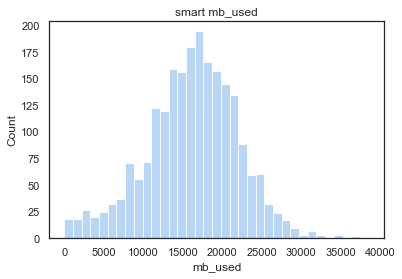

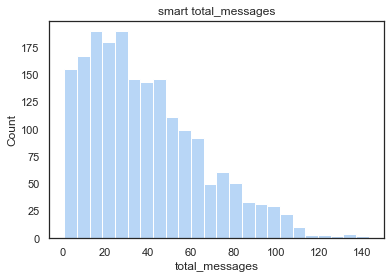

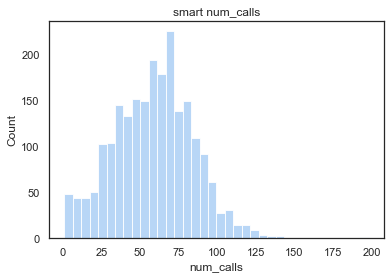

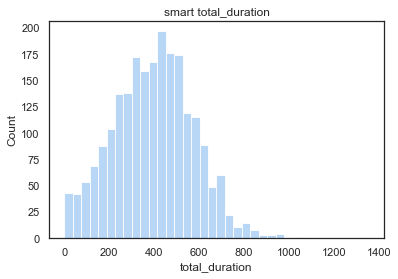

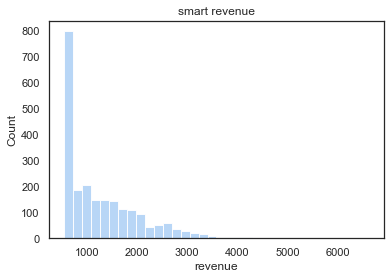

In [43]:
cols = ['mb_used', 'total_messages', 'num_calls', 'total_duration', 'revenue']

for i in cols:
    plt.figure()
    sns.histplot(df[df['tariff'] == 'smart'][i]).set(title='smart '+i)

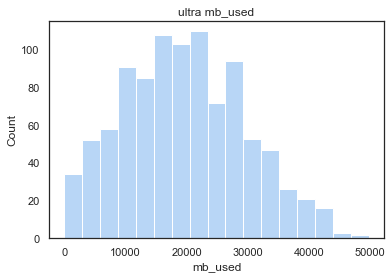

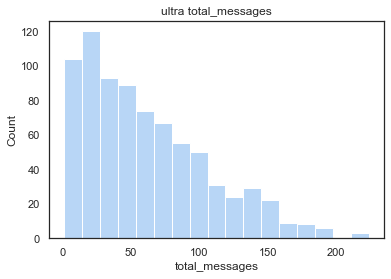

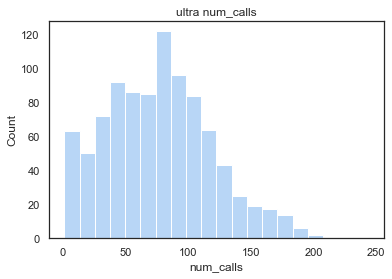

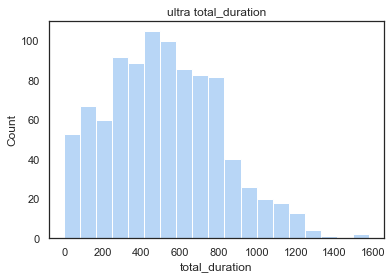

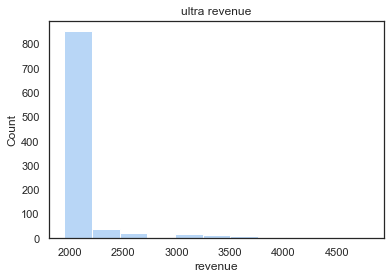

In [44]:
for i in cols:
    plt.figure()
    sns.histplot(data=df[df['tariff'] == 'ultra'], x=i).set(title='ultra '+i)

Распределения выглядят реальными. По данным можно делать выводы

Посчитаем среднее, дисперсию и стандартное отклонение выборки по тарифам за каждый месяц

In [45]:
cols = ['mb_used', 'total_messages', 'num_calls', 'total_duration']

for i in cols:
    print(i)
    display(df[df['tariff'] == 'smart'].groupby('month')[i].agg({'mean', 'var', 'std'}))

mb_used


,std,mean,var
month,,,
1,6444.681014,8513.717647,4.153391e+07
2,6247.353833,11597.054310,3.902943e+07
3,5828.237537,15104.159091,3.396835e+07
4,5698.249092,13462.180625,3.247004e+07
5,5978.231725,15805.184326,3.573925e+07
6,5791.155586,15794.647988,3.353748e+07
7,5897.154446,15743.150348,3.477643e+07
8,5498.387304,16681.706068,3.023226e+07
9,5196.115749,16303.578808,2.699962e+07


total_messages


,std,mean,var
month,,,
1,15.878707,20.000000,252.133333
2,20.987275,27.940000,440.465714
3,25.880117,35.550725,669.780477
4,22.756662,35.864583,517.865680
5,25.274014,39.032787,638.775776
6,27.048767,38.577465,731.635801
7,26.820747,38.988506,719.352468
8,27.639132,38.935961,763.921621
9,26.504821,39.219731,702.505555


num_calls


,std,mean,var
month,,,
1,20.811886,27.676471,433.134581
2,25.394057,40.189655,644.858137
3,25.536579,54.324675,652.116883
4,25.704850,51.312500,660.739302
5,25.376846,55.241135,643.984296
6,23.549791,55.889571,554.592668
7,24.629652,56.726368,606.619751
8,24.741596,59.467811,612.146589
9,24.769246,59.776062,613.515549


total_duration


,std,mean,var
month,,,
1,146.328341,193.042353,21411.983376
2,180.979000,282.963448,32753.398595
3,181.537643,367.877143,32955.915700
4,176.103248,346.222589,31012.354057
5,176.543314,365.214752,31167.541667
6,163.555898,375.481595,26750.531795
7,169.750528,385.498557,28815.241893
8,173.711891,401.105536,30175.820974
9,171.774291,406.081081,29506.406953


In [46]:
for i in cols:
    print(i)
    display(df[df['tariff'] == 'ultra'].groupby('month')[i].agg({'mean', 'var', 'std'}))

mb_used


,std,mean,var
month,,,
1,6865.346875,13140.681111,4.713299e+07
2,10473.403015,12846.477273,1.096922e+08
3,10951.785885,17535.550270,1.199416e+08
4,9718.649845,16828.134364,9.445215e+07
5,9829.620332,19656.534091,9.662144e+07
6,9109.904861,19152.950602,8.299037e+07
7,9883.022284,20723.394778,9.767413e+07
8,10349.849601,19760.734434,1.071194e+08
9,9353.599420,19372.735702,8.748982e+07


total_messages


,std,mean,var
month,,,
1,27.663798,43.428571,765.285714
2,25.694742,37.285714,660.219780
3,42.739521,47.800000,1826.666667
4,37.526743,44.512821,1408.256410
5,39.686517,49.313725,1575.019608
6,44.297324,52.530303,1962.252914
7,47.037891,62.486111,2212.563185
8,45.196479,59.103448,2042.721732
9,43.779257,63.627660,1916.623313


num_calls


,std,mean,var
month,,,
1,41.638657,59.444444,1733.777778
2,41.718600,44.181818,1740.441558
3,44.838013,67.675676,2010.447447
4,34.674100,66.509434,1202.293179
5,38.549594,76.730159,1486.071173
6,38.447655,69.575000,1478.222152
7,41.283750,78.758621,1704.348035
8,42.138839,74.264706,1775.681712
9,42.778445,77.690909,1829.995329


total_duration


,std,mean,var
month,,,
1,254.624034,404.777778,64833.398744
2,286.523987,297.872273,82095.994866
3,315.684713,462.359730,99656.837903
4,242.972410,448.188491,59035.591921
5,257.724131,508.995714,66421.727454
6,278.089169,472.879000,77333.585898
7,278.341276,536.229310,77473.865737
8,284.980479,503.304706,81213.873530
9,295.994269,530.340818,87612.607576


In [47]:
smart = df[df['tariff'] == 'smart']
ultra = df[df['tariff'] == 'ultra']

Графики по тарифам и месяцам:

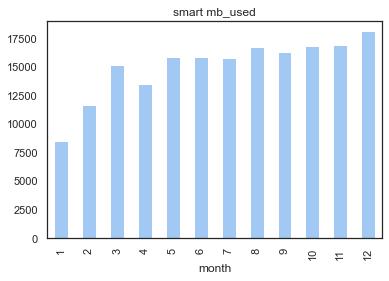

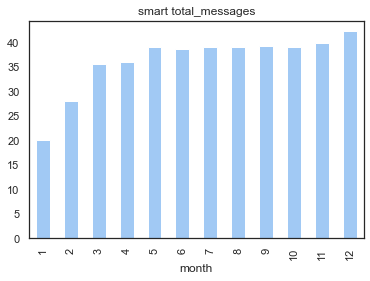

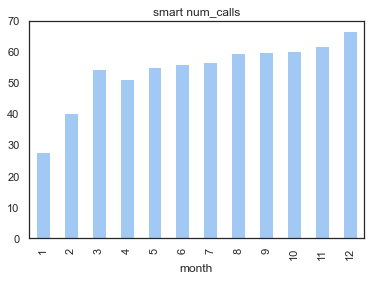

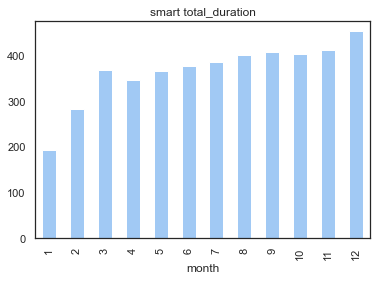

In [48]:
for i in cols:
    plt.figure(i)
    smart.groupby('month')[i].mean().plot(kind='bar', title=f'smart {i}')

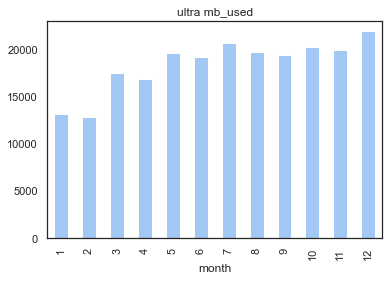

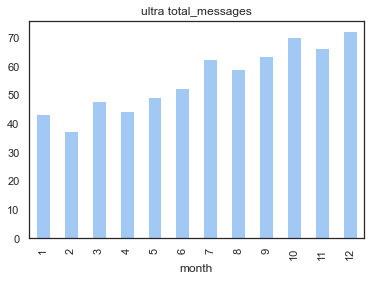

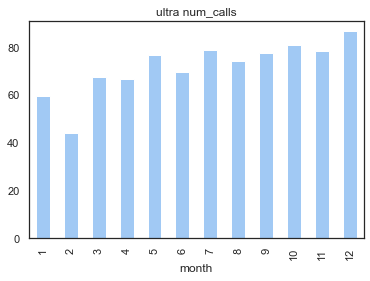

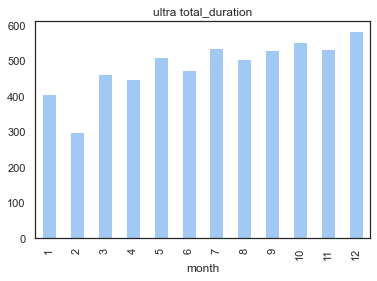

In [49]:
for i in cols:
    plt.figure(i)
    ultra.groupby('month')[i].mean().plot(kind='bar', title=f'ultra {i}')

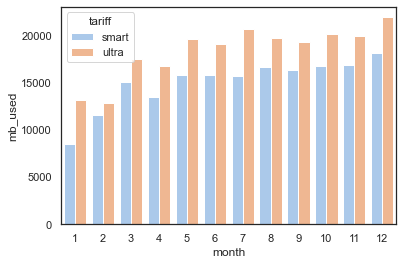

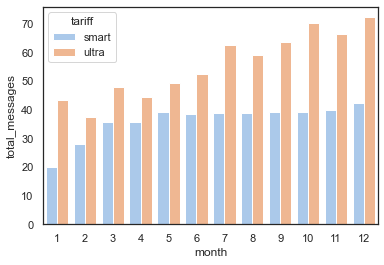

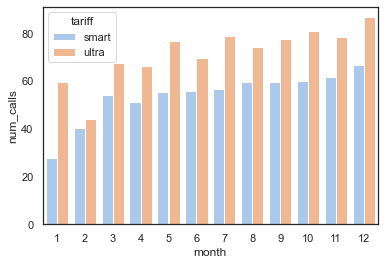

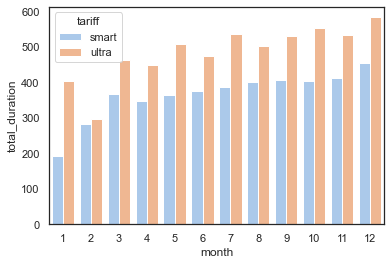

In [50]:
for i in cols:
    plt.figure(i)
    dots = df.groupby(['tariff', 'month'])[i].mean().reset_index()
    sns.barplot(data=dots, x='month', y=i, hue='tariff')

<AxesSubplot:xlabel='month', ylabel='revenue'>

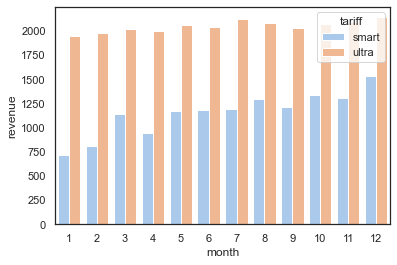

In [51]:
rev_tariff_month = df.groupby(['tariff', 'month'])['revenue'].mean().reset_index()
sns.barplot(data=rev_tariff_month, x='month', y='revenue', hue='tariff')

<AxesSubplot:xlabel='tariff', ylabel='revenue'>

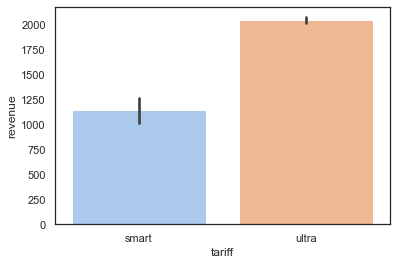

In [52]:
sns.barplot(data=rev_tariff_month, y='revenue', x='tariff')

Из графиков видно, что от начала года к его концу потребление всех видов связи растет. В какие то месяцы бывают провалы, но в целом к концу года показатели увеличиваются.

Средние показатели по каждому тарифу в месяц различны, значения больше у более дорогого тарифа, потому как тарифных звонков, месседжей и интернета там больше.


upd
По финальному графику доходов тарифов в каждый месяц видно, что тариф `ultra` приносит в среднем каждый месяц примерно в два раза больше денег, чем `smart`. Так же тратят связи больше на тарифе `ultra`.

## Проверка гипотез

У нас есть две гипотезы, которые необходимо проверить:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Пороговое значение уровня значимости alpha обозначим в 5%.

Первая гипотеза: 

средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Тогда **H0** будет звучать так:

_Средние значение выручки тарифов Ультра и Смарт имеют значимые различия_

**H1** - _Средние значение выручки тарифов Ультра и Смарт не имеют значимых различий_

Чтобы это проверить, нужно выбрать тест, который будем использовать.

Это будет t-test для двух независимых выборок. Выбираем именно его, потому что выборки у нас независимые(не парные) и их две. Так же нужно учесть, что дисперсия будет разной и размеры выборок тоже, поэтому нужно указать параметр `equal_var = False`

In [53]:
alpha = 0.05

res = st.ttest_ind(
    smart.groupby('month')['revenue'].mean(),
    ultra.groupby('month')['revenue'].mean(),
    equal_var=False)

print(f'p-value: {res.pvalue}')
if res.pvalue < alpha:
    print('Есть значимые различия, отвергаем H0')
else:
    print('Нет значимых различий, отвергаем H1')

p-value: 1.2504272593344577e-08
Есть значимые различия, отвергаем H0


Проверим вторую гипотезу: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**H0** - _Средняя выручка пользователей Москвы имеет значимые различия сравнимо с пользователями других регионов_

**H1** - _Средняя выручка пользователей Москвы не имеет значимых различий сравнимо с пользователями других регионов_

Тест будем применять такой же как и в первый раз.

In [54]:
# Проверили значения, чтобы убедиться, что Москва тут только одна
df['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [55]:
moscow = df[df['city'] == 'Москва']
others = df[df['city'] != 'Москва']

alpha = .05

res = st.ttest_ind(moscow.groupby('month')['revenue'].mean(), 
                   others.groupby('month')['revenue'].mean(),
                   equal_var=False)

print(f'pvalue: {res.pvalue}')
if res.pvalue < alpha:
    print('Есть значимые различия, отвергаем H0')
else:
    print('Нет значимых различий, отвергаем H1')

pvalue: 0.22685366511333724
Нет значимых различий, отвергаем H1


## Вывод

Были изучены данные по 500 пользователям компании "Мегалайн". В данных не было обнаружено пропусков.

Анализ данных показал, что помесячно за год в среднем потребление услуг увеличивалось.

Так же были рассмотрены и проверены две гипотезы. По результатам тестов можно утверждать, что по данной выборке средние значения выручки у двух тарифов имеют существенные различия и, что Московская выручка и выручка с остальных регионов не отличается.

Графики общей выручки по месяцам и за год показывают, что тариф `ultra` приносит значительно больше денег. Гипотеза о существенном различии выручки это так же подтверждает(максимальная выручка в месяц у тарифа `smart` примерно 1500, у тарифа `ultra` около 2000). Я бы рекомендовал увеличить рекламный бюджет в пользу тарифа `ultra`. 

Так же было бы хорошо провести новое исследование - проанализировать ценовую политику менее доходного тарифа `smart` и понять, как можно увеличить его показатели выручки.